# Train a variational autoencoder to perform clustering on the MNIST data set.

With this exercises I'm trying to learn the basics of training an ANN with Keras.

I will define and train a VAE on the MNIST data set based on what I learned from the book "Deep Learning with Python" (available at https://livebook.manning.com/book/deep-learning-with-python-second-edition/deep-learning-with-python/).

Then I will perform clustering on the codings.

# Load some libraries and the MNIST data set

## Import libraries
Import the necessary libraries to run this notebook:

In [1]:
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import pandas as pd
import seaborn as sns

## Load and prepare the MNIST data set

Load de MNIST data set form Keras:

In [2]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

11490434/11490434 [==============================] - 0s 0us/step


Show the first image and some properties:

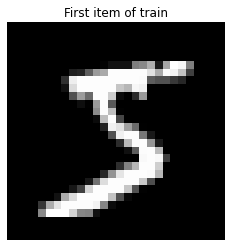

Label: 5
Shape: (28, 28)
Max/min: 255 0


In [3]:
plt.imshow(x_train[0].reshape(28,28))
plt.axis('off')
plt.set_cmap('gray')
plt.title("First item of train")
plt.show()
print("Label:", y_train[0])
print("Shape:", x_train[0].shape)
print("Max/min:", x_train[0].max(), x_train[0].min())

The VAE implements self-supervised learning, so we can train it with all the images on MNIST. We don't need to separete train and test sets. So we combine them all:

In [4]:
images = np.concatenate([x_train, x_test], axis=0)
labels = np.concatenate([y_train, y_test], axis=0)

We need to adapt the input to fit the network: add one dimension and rescale the values so the range from 0 to 1.

In [5]:
images = np.expand_dims(images, -1).astype("float")/255

We now have 70.000 images (and labels) to train the network.

In [6]:
print("images shape:", images.shape)
print("labels shape:", labels.shape)

images shape: (70000, 28, 28, 1)
labels shape: (70000,)


# VAE model

Since the input for the VAE will be an image, we will reuse de CNN architecture we found on the exercise "MNIST_classifier_CNN2".

## Define the encoder

We start by defining the encoder. It will take a 28x28 image as an input and otuput a two dimensional latent space that will define two normal distributions, defined by their mean an variance (taken as log variance).

In [7]:
# Some things we could tweak later:
conv_filters = [32, 64]
dropout_rate = 0.5
latent_dim = 2

# Input layer
encoder_inputs = keras.Input(shape=(28, 28, 1), name="inputs")
x = encoder_inputs

# Convolutional layers
for f in conv_filters:
    x = layers.Conv2D(f, 3,
                      padding="same",
                      activation="relu",
                      name="conv_1_"+str(f)) (x)
    x = layers.Conv2D(f, 3, 
                      padding="same", 
                      activation="relu",
                      name="conv_2_"+str(f)) (x)
    x = layers.Conv2D(f, 3, 
                      padding="same",
                      strides=2, 
                      activation="relu",
                      name="strides_"+str(f)) (x)
    x = layers.BatchNormalization(name="norm_"+str(f)) (x)
    x = layers.Dropout(dropout_rate, name="dropout_"+str(f)) (x)

# Dense layer before the output
x = layers.Flatten(name="flatten") (x)
x = layers.Dense(16, activation="relu", name="dense") (x)

# Output layers
z_mean = layers.Dense(latent_dim, name="z_mean") (x)
z_log_var = layers.Dense(latent_dim, name="z_log_var") (x)

# Define the encoder and show its summary
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv_1_32 (Conv2D)             (None, 28, 28, 32)   320         ['inputs[0][0]']                 
                                                                                                  
 conv_2_32 (Conv2D)             (None, 28, 28, 32)   9248        ['conv_1_32[0][0]']              
                                                                                                  
 strides_32 (Conv2D)            (None, 14, 14, 32)   9248        ['conv_2_32[0][0]']              
                                                                                            

## Define the decoder

We need a bridge layer between the encoder and the decoder. We need to sample a point from the distribution generated by the encoder, so we can feed it to the decoder.

In [8]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

No we can define the decoder. It will take as an input a points from the latent space and output a reconstruted image.

In [9]:
# Input layer
decoder_inputs = keras.Input(shape=(latent_dim,))

# Dense layers to revert the ones on the encoder
x = layers.Dense(7 * 7 * 64, activation="relu") (decoder_inputs)
x = layers.Reshape((7, 7, 64)) (x)

# Deconvolution layers
for f in conv_filters[::-1]: # reverse order
    x = layers.Conv2DTranspose(f, 3,
                               padding="same",
                               strides=2, 
                               activation="relu",
                               name="strides_1_"+str(f)) (x)
    x = layers.Conv2DTranspose(f, 3, 
                      padding="same", 
                      activation="relu",
                      name="deconv_1_"+str(f)) (x)
    x = layers.Conv2DTranspose(f, 3, 
                      padding="same", 
                      activation="relu",
                      name="deconv_2_"+str(f)) (x)
    x = layers.BatchNormalization(name="norm_"+str(f)) (x)
    x = layers.Dropout(dropout_rate, name="dropout_"+str(f)) (x)

    
# Output layer
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same") (x)

# Define the encoder and show its summary
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 strides_1_64 (Conv2DTranspo  (None, 14, 14, 64)       36928     
 se)                                                             
                                                                 
 deconv_1_64 (Conv2DTranspos  (None, 14, 14, 64)       36928     
 e)                                                              
                                                                 
 deconv_2_64 (Conv2DTranspos  (None, 14, 14, 64)       3692

## Define the VAE model

We will define it as a subclass model with a custom `train_step()` function, where we will program the custom metrics (reconstruction loss and KL loss)

In [10]:
#ToDo: comment code
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        # Declare the three parts of the VAE
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Declare the custom metrics
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    # List the metrics in the metrics property to allow the model to reset them after each epoch
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    # Custom train step
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Reconstruction loss: sum the loss over the two dimension of the image, then take the mean of the batch
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL loss: compute the KL-divergence
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # Total loss: sum the two losses
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
            # Compute the gradient with the total loss and update trainable weights
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # Update the metrics with the new values
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            # Return the metrics as a dictionary
            return {
                "total_loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()
            }

## Train the model

Compile the model:

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

Define a callbacks list to save the best performing model during training

In [13]:
# Note1: Saving the model is not that easy for a custom class. We'll have to look how we can do it.
# callbacks_list = [
#     # save the best model
#     keras.callbacks.ModelCheckpoint(
#         "vae.tf",
#         save_format="tf",
#         save_best_only = True,
#         monitor = "total_loss",
#     )
# ]

And train the model

In [15]:
vae.fit(images,
        epochs=50,
        batch_size=128,
        # callbacks = callbacks_list, #See Note1 on previous chunck
        verbose = 1,
       )

Or we can instead load the weights of a model we trained on a previous run:

In [14]:
# Load the already trained weights instead of re-training the model
vae.load_weights("model/vae_weights")

## Save the model and the codings

In [ ]:
# Save the model
# vae.save("vae", save_format='tf') #gives error
vae.save_weights("model/vae_weights")

In [ ]:
# We alse could instantiate a new model and load the trained weigths:
# newvae = VAE(encoder, decoder)
# newvae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# newvae.load_weights("model/vae_weights")

In [16]:
# Generate the codings
codings_mean, codings_logvar = vae.encoder.predict(images)

2188/2188 [==============================] - 12s 2ms/step


In [ ]:
# Save them to a file for later
np.savetxt("codings/mean.csv", codings_mean)
np.savetxt("codings/logvar.csv", codings_logvar)

## Visualize the latent space

Take points from a 30x30 grid on the latent space and regenerate the images. Save all of them on a single image.

In [ ]:
n = 30
res = 28

img_latent_space = np.zeros((res * n, res * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::1]

for i, yi in enumerate(grid_y):
    print("decoding row", i+1, "of", n)
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(res, res)
        img_latent_space[i * res : (i + 1) * res,
                         j * res : (j + 1) * res] = digit

decoding row 1 of 30
decoding row 2 of 30
decoding row 3 of 30
decoding row 4 of 30
decoding row 5 of 30
decoding row 6 of 30
decoding row 7 of 30
decoding row 8 of 30
decoding row 9 of 30
decoding row 10 of 30
decoding row 11 of 30
decoding row 12 of 30
decoding row 13 of 30
decoding row 14 of 30
decoding row 15 of 30
decoding row 16 of 30
decoding row 17 of 30
decoding row 18 of 30
decoding row 19 of 30
decoding row 20 of 30
decoding row 21 of 30
decoding row 22 of 30
decoding row 23 of 30
decoding row 24 of 30
decoding row 25 of 30
decoding row 26 of 30
decoding row 27 of 30
decoding row 28 of 30
decoding row 29 of 30
decoding row 30 of 30


And show them.

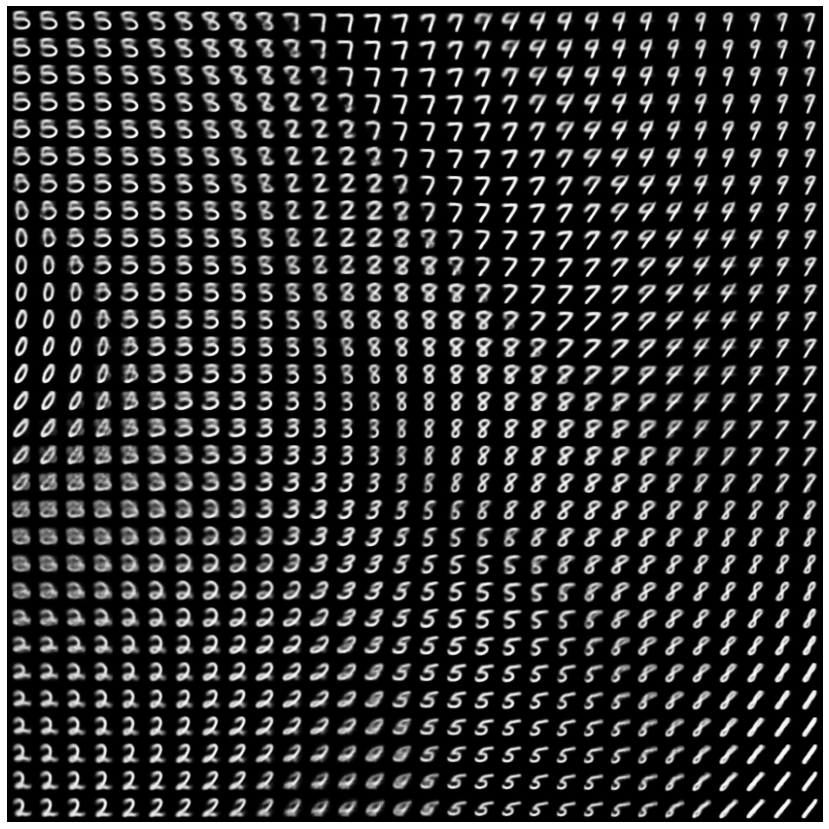

In [ ]:
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(img_latent_space, cmap="Greys_r")

## Compare an original image with its reconstruction

1/1 [==============================] - 0s 24ms/step


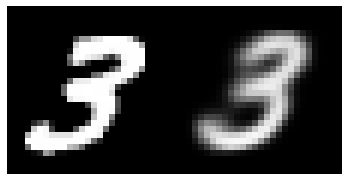

In [109]:
# Input image index (chose between 1 and 70.000)
num = 12355

res = 28
figure = np.zeros((res, res*2))

# Save the original image
figure[0:res, 0:res] = images[num].reshape(res, res)

# Encode it
z_mean, z_logvar = vae.encoder.predict(images[[num]])
# Decode it (use the predicted mean, no need to sample from the distribution)
x_decoded = vae.decoder.predict(z_mean)
# Save the the reconstructed image
reconstructed_img = x_decoded[0].reshape(res, res)
figure[0:res, res:res*2] = reconstructed_img

# Show original and reconstructed
plt.figure()
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

## Perform K-means clustering on embeddings

Try a range of `k` values and plot the SSE. We should expect good clustering with `k=10`.

computing for k = 3
computing for k = 4
computing for k = 5
computing for k = 6
computing for k = 7
computing for k = 8
computing for k = 9
computing for k = 10
computing for k = 11
computing for k = 12
computing for k = 13
computing for k = 14
computing for k = 15


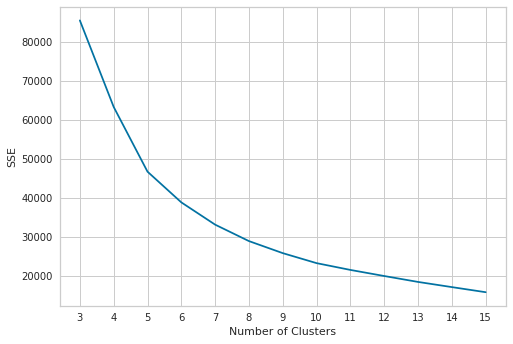

In [ ]:
k_vals = np.arange(3, 16)
sse = []

for k in k_vals:
    print("computing for k =", k)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(codings_mean)
    sse.append(kmeans.inertia_)
    
plt.plot(k_vals, sse)
plt.xticks(k_vals)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

It looks like we have an elbow on k=7. We will take k=10 since we know we have 10 numbers in the data set.

We can make a contingency table of the clusters and the original labels and show it as a heatmap:

[Text(33.0, 0.5, 'labels'), Text(0.5, 15.0, 'clusters')]

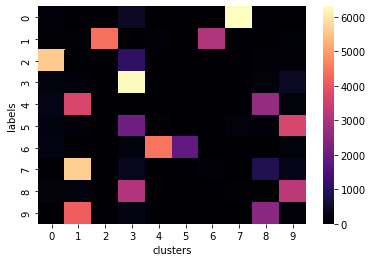

In [187]:
k=10

kmeans = KMeans(n_clusters=k)
kmeans.fit(codings_mean)

crosstab = pd.crosstab(labels, kmeans.labels_)
heatmap = sns.heatmap(crosstab,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='labels')

Some clusters de relate to the labels (for example, almost all 0's are contained in cluster number 5, which dosen't contain almost any other label). But some labels are separated in multiple clusters, and some clusters contain more than one label.

We can define each cluster "label" as the more freqüent label in each one. Then, we can compare each original label withe the cluster label and compute the precision.

In [191]:
positives = 0
for i,label in enumerate(labels):
    clust = kmeans.labels_[i]
    clust_label = crosstab[clust].idxmax()
    if label == clust_label:
      positives += 1
precision = positives/len(labels)
print("precision:", precision*100)

precision: 62.755714285714284


We can take the centroid of each group and reconstruct an image with the decoder.

1/1 [==============================] - 2s 2s/step


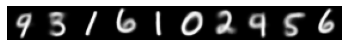

In [18]:
centroids = kmeans.cluster_centers_

res = 28
figure = np.zeros((res, res*k))

decoded_centroids = vae.decoder.predict(centroids)

for i,x in enumerate(decoded_centroids):
    reconstructed_img = x.reshape(res, res)
    figure[0:res, i*res:(i+1)*res] = reconstructed_img

# Show original and reconstructed
plt.figure()
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

As we saw before, cluster 5 generated a zero. But there are two sixes, two nines and two ones.

We can draw each centroid reconstruction over the latent space representation:

decoding col 1 of 20
decoding col 2 of 20
decoding col 3 of 20
decoding col 4 of 20
decoding col 5 of 20
decoding col 6 of 20
decoding col 7 of 20
decoding col 8 of 20
decoding col 9 of 20
decoding col 10 of 20
decoding col 11 of 20
decoding col 12 of 20
decoding col 13 of 20
decoding col 14 of 20
decoding col 15 of 20
decoding col 16 of 20
decoding col 17 of 20
decoding col 18 of 20
decoding col 19 of 20
decoding col 20 of 20


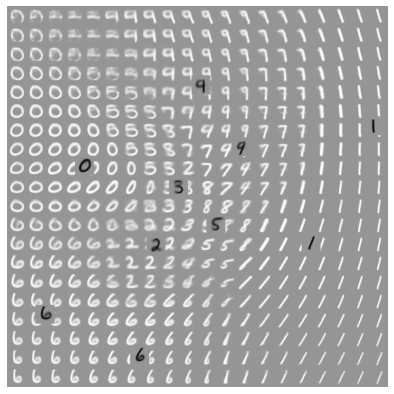

In [19]:
n = 20   # Number of points per row and column
res = 28 # Resolution of each reconstructed image
lim = 3  # Inferior and superior range for the latent space

# Initialize a blank image
im_res = n * res
img = np.zeros((im_res, im_res))

# Draw the latent space representation
grid_x = np.linspace(-1*lim, lim, n)
grid_y = np.linspace(-1*lim, lim, n)[::1]

for i, yi in enumerate(grid_y):
    print("decoding col", i+1, "of", n)
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(res, res)
        img[i*res : (i+1)*res,
            j*res : (j+1)*res] = digit

# Draw the centroids reconstrucions
for i,centroid in enumerate(centroids):
    # Compute the coordinates
    y,x = ((1 + centroid / lim) * im_res / 2).astype("int")
    # Reconstruct the image
    recon = decoded_centroids[i].reshape(res, res)
    # Draw the image (inverted for contrast)
    img[x-res//2:x+res//2, y-res//2:y+res//2] = recon * (-1)
        
# Show the image
plt.figure(figsize=(7, 7))
plt.axis("off")
plt.imshow(img, cmap="Greys_r")

Maybe it will be clearer if we plot the embeddings on the latent space and paint each label one color. We will also plot the cluster centroids on top:

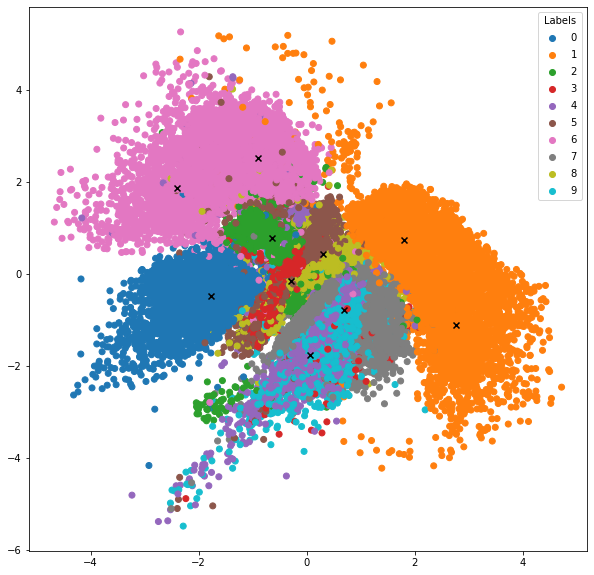

In [103]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(codings_mean[:,0],
                      codings_mean[:,1],
                      label=labels,
                      c=labels,
                      cmap="tab10",
                      )
plt.scatter(centroids[:,0],
            centroids[:,1],
            c="black",
            marker="x",
            )
plt.legend(*scatter.legend_elements(), title="Labels")
plt.show()

As we saw before, the "sixes" have two centroids on them and the same happens with the "ones". Also, there are four centroids that do not fall neatly over any label.

Let's repeat the plot but color the clusters instead of the labels:

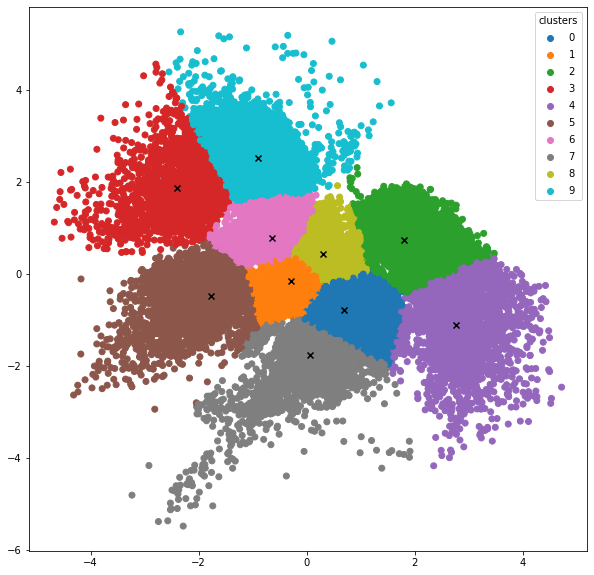

In [104]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(codings_mean[:,0],
                      codings_mean[:,1],
                      label=kmeans.labels_,
                      c=kmeans.labels_,
                      cmap="tab10",
                      )
plt.scatter(centroids[:,0],
            centroids[:,1],
            c="black",
            marker="x",
            )
plt.legend(*scatter.legend_elements(), title="clusters")
plt.show()

Again, we can see that the zeros are well define by the cluster 5. Clusters 3 and 9 seem to contain the sixes, and clusters 2 and 4 seem to contain the ones.

Cluster 6 contains all the twos, but also some other labels. The other clusters contain a mixture of labels.

It seems that the latent space we obtained does not lend itself to a good clustering result. But we only applied the reconstruction loss and KL divergence loss (i.e., non-clustering losses) while training. We should fine-tune the weights applyng a clustering loss and see if we can obtain a better result.

## For reference: K-means over raw MNIST images

To have something to compare, lets analyse the clusters we could have obtained from the raw images:

Shape before: (28, 28, 1)
Shape after: (784,)


[Text(33.0, 0.5, 'labels'), Text(0.5, 15.0, 'clusters')]

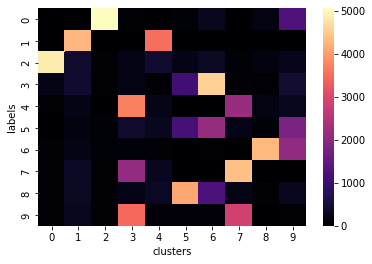

In [192]:
# Reshape the 70.000 28x28x1 images to arrays of length 784
print("Shape before:", images[0].shape)
img_arrays = images.reshape(70000,-1)
print("Shape after:", img_arrays[0].shape)

k=10

kmeans_raw = KMeans(n_clusters=k)
kmeans_raw.fit(img_arrays)

crosstab = pd.crosstab(labels, kmeans_raw.labels_)
heatmap = sns.heatmap(crosstab,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='labels')

Let's compute the precision the same way as before

In [193]:
positives = 0
for i,label in enumerate(labels):
    clust = kmeans_raw.labels_[i]
    clust_label = crosstab[clust].idxmax()
    if label == clust_label:
      positives += 1
precision = positives/len(labels)
print("precision:", precision*100)

precision: 58.502857142857145


But we did lower the SSE by a lot:

In [198]:
print("SSE of kmeans over raw images:", kmeans_raw.inertia_)
print("SSE of kmeans over embeddings:", kmeans.inertia_)

SSE of kmeans over raw images: 2744056.3881029086
SSE of kmeans over embeddings: 23179.60546875


We dind't do much better with the embeddings.

Let's plot them and color the clusters from the raw images.

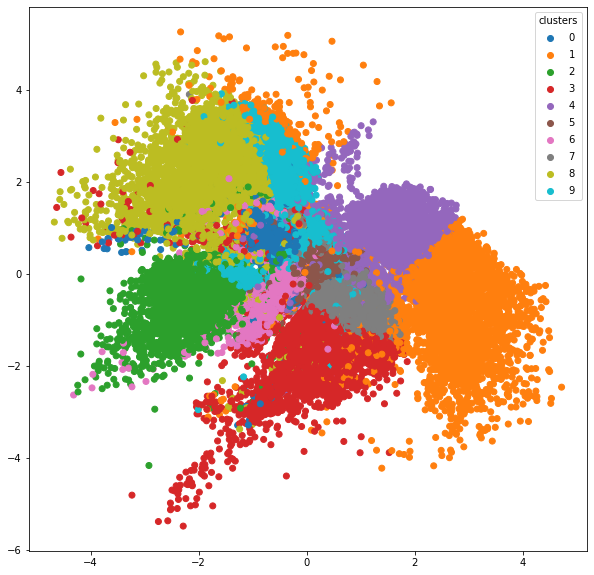

In [195]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(codings_mean[:,0],
                      codings_mean[:,1],
                      label=kmeans_raw.labels_,
                      c=kmeans_raw.labels_,
                      cmap="tab10",
                      )
plt.legend(*scatter.legend_elements(), title="clusters")
plt.show()

The clusters are much more scattered, but they seem to loosely adjust to the labels.

# ToDo:

## Comment
- Comment chunk on 3.3, explain what we are doing.

## Save model
- Learn how to save a custom class model
- Redefine callbacks and try to train the model for longer, saving the best performance.

## Clustering
- Define clustering loss
- Fine-tune model with clustering loss